In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from multiprocessing.pool import ThreadPool
from multiprocessing import cpu_count
max_cpu = cpu_count()

# Homework (Lecture 9)
## Problem 1

### Part (a)

$X_i \sim Exp(\lambda), \lambda >0 $

$\displaystyle \sum_{i=1}^{100} \log(\lambda e^{-\lambda X_i}) \cdot 1(X_i > 0) = \sum_{i=1}^{100} \log(\lambda e^{-\lambda X_i}) = 100 log(\lambda) - \lambda \sum_{i=1}^{100} X_i$

$\frac{\partial}{\partial \lambda} ( 100 log(\lambda) - \lambda \sum_{i=1}^{100} X_i) = \frac{100}{\lambda} - \sum_i X_i \Rightarrow \hat{\lambda} = \displaystyle \frac{1}{\bar{X}}$

To find the asymptotic variance of $\hat{\lambda}$, we can apply the Delta Method. In particular, since $\sqrt{n} (\bar{X} - \mu) \overset{d}{\to} N(0, \sigma^2)$, where $\mu = \displaystyle \frac{1}{\lambda}, \sigma^2 = \frac{1}{\lambda^2}$, we can say that $\sqrt{n} (\hat{\lambda} - \lambda) \overset{d}{\to} N(0, \sigma^2 \cdot  (\frac{1}{-\frac{1}{\lambda^2}})^2) = N(0, \lambda^2)$. The asymptotic variance of the MLE estimator is $\lambda^2$.

### Part (b)

Given $\hat{\lambda}^{MLE}$, we can use the estimated CDF of X to find $\displaystyle P(X \le 1) = 1- e^{-\lambda \cdot 1} = 1- e^{-\hat{\lambda}^{MLE}} = 1- e^{-\frac{1}{\bar{X}}}$.

### Part (c)

Similarly to Part (a), since we have $\displaystyle \sqrt{n} (\bar{X} - \frac{1}{\lambda}) \overset{d}{\to} N(0, \frac{1}{\lambda^2})$, to construct a 95% CI for $P(X \le 1)$, we can show that $\displaystyle \sqrt{n} (\hat{P} - P) \overset{d}{\to} N(0, \frac{1}{\lambda^2} \cdot (1+e^{-\lambda})^2) = N(0, (\frac{1+e^{-\lambda}}{\lambda})^2 )$

Now that we have the asymptotic variance of this estimator, we can construct a 95% CI: $\hat{p} \pm 1.96 \times se(\hat{p}) = 1- e^{-\frac{1}{\bar{X}}} \pm 1.96 \times \frac{\sigma}{\sqrt{n}} = 0.9179 \pm 0.08484$

### Part (d)

$\hat{P}(X \le 1) = 0.8 \Rightarrow \frac{1}{n} \sum_{i=1}^{100} 1(X \le 1) = 0.8$. Since the sum of Bernoulli random variables follows a binomial distribution, we know the variance is $npq = (100)(0.8)(0.2) = 16$. By the CLT, we see that $\hat{p}_n \sim N(\mu, \frac{\sigma^2}{n}) = N(0.8,0.16)$. As such, a 95% CI for $\hat{p}_n$ is: $\hat{p}_n \pm 1.96 \times se(\hat{p}_n) = 0.8 \pm 0.0784$

### Part (e)

I would trust the one from Part (d) more since it makes fewer assumptions about the true distribution of the data.

## Problem 2

### Part (a)

In [6]:
def DGP():
    V = np.random.exponential(scale=2,size = 200)
    X = 1 + V
    epsilon = np.random.normal(0,np.sqrt(0.5),size=200)
    Y = 2 + 2 * np.log(X) + epsilon
    return X, Y

def gauss_kernel(u):
    return (1/np.sqrt(2*np.pi)) * np.exp(-(u ** 2)/2)

def LL(X,Y,x,h):
    Z = np.column_stack((np.ones((1,200)),X-x))
    K = np.diag(gauss_kernel((X-x)/h))
    m_vec = np.linalg.inv(Z.T @ K @ Z) @ Z.T @ K @ Y
    return m_vec[0], m_vec[1]

def NN(X,Y,x,k):
    x_norm = np.abs(X-x)
    m = (1/k) * np.sum(np.sort(np.column_stack((x_norm,Y)),axis=0)[-k:,1])
    return m

def series(X,Y,x):
    pass

In [ ]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.BSpline.html

# Homework (Lecture 11)

## Problem 1

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error

In [90]:
def DGP():
    X = np.random.rand(300,2)
    y = X.sum(axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=100, random_state=31)
    return X_train, X_test, y_train, y_test

def tree_cv(param):
    X_train, X_test, y_train, y_test = DGP()
    model = DecisionTreeRegressor(ccp_alpha = param, random_state=31)
    cv_scores = cross_val_score(model,X_train,y_train,cv=5,scoring='neg_mean_squared_error')
    return param, -cv_scores.sum()

def rf_cv(param):
    X_train, X_test, y_train, y_test = DGP()
    model = RandomForestRegressor(max_features = param, n_jobs = -1, random_state=31)
    cv_scores = cross_val_score(model,X_train,y_train,cv=5,scoring='neg_mean_squared_error')
    return param, -cv_scores.sum()

def boost_cv(param):
    X_train, X_test, y_train, y_test = DGP()
    model = GradientBoostingRegressor(max_leaf_nodes = param, random_state=31)
    cv_scores = cross_val_score(model,X_train,y_train,cv=5,scoring='neg_mean_squared_error')
    return param, -cv_scores.sum()

def cv_viz(fn,params):
    with ThreadPool(max_cpu - 1) as pool:
        output = pool.map(fn,params)
    df = pd.DataFrame(output,columns=['Parameter','MSE'])
    plt.figure(figsize=[8,5])
    plt.scatter(x = df['Parameter'], y = df['MSE'])
    plt.xlabel('Parameter Value')
    plt.ylabel('MSE')

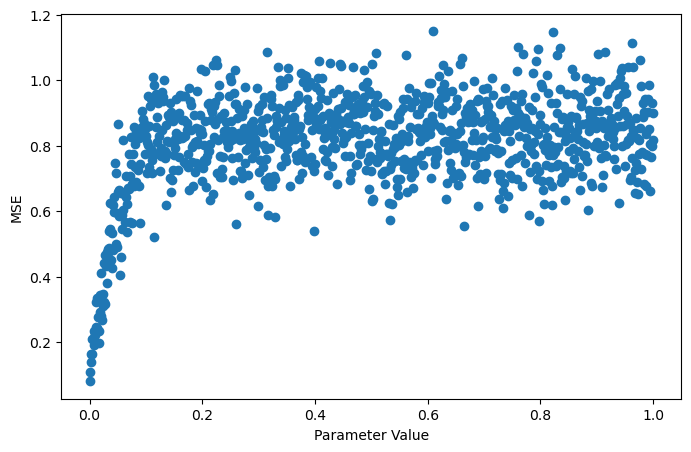

In [91]:
params = np.linspace(0,1,1000)
cv_viz(tree_cv,params)

In [ ]:
params = np.linspace(1,100,1000,dtype=int)
cv_viz(rf_cv,params)

In [ ]:
params = np.linspace(1,100,10,dtype=int)
cv_viz(boost_cv,params)

Note:

**DON'T FORGET TO SET RANDOM STATE FOR EACH MODEL**

- for tree, use ccp_alpha parameter for tuning - Minimal cost-complexity pruning based on Chapter 3 of Breiman et al (1984)
- for rf, select num regressors for each split p using max_features: The number of features to consider when looking for the best split
- for boosted tree, choose number of leaves using max_leaf_nodes parameter

In [ ]:
# training optimal models
X_train, X_test, y_train, y_test = DGP()

tree = DecisionTreeRegressor(ccp_alpha = 0, random_state=31).fit(X_train,y_train)
rf = RandomForestRegressor(max_features = param, n_jobs = -1, random_state=31).fit(X_train,y_train)
bost = GradientBoostingRegressor(max_leaf_nodes = param, random_state=31).fit(X_train,y_train)

In [ ]:
print('Tree:')
mean_squared_error(y_test, tree.predict(X_test))

print('RF:')
mean_squared_error(y_test, rf.predict(X_test))

print('Boost:')
mean_squared_error(y_test, boost.predict(X_test))

## Problem 2

### Part (1)

In [17]:
df = pd.read_csv('penn.csv')